In [2]:
import sys
import numpy as np
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt
import scipy.interpolate
sys.path.insert(0, "../Code")
import Setup as p
from astropy.io import ascii, fits

In [3]:
cat = fits.open("../../BAM/a100springfull.fits")[1].data

In [27]:
logw50 = np.log10(cat['W50'])
logMH = cat['logMH']
print(np.min(logw50), np.max(logw50))
print(np.min(logMH), np.max(logMH))

1.20412 2.94694
6.07 10.85


In [21]:
# Load data
MFWascii = ascii.read("../../Data/HIdata/a100.180315.MWF.csv")
MFWascii_errors = ascii.read("../../Data/HIdata/a100.180315.MWF_err.csv")
MFW = np.zeros(shape=(25, 18))
MFWerrors = np.zeros(shape=(25, 18))
for i in range(25):
    for j in range(18):
        MFW[i, j] = MFWascii[i][j]
        MFWerrors[i, j] = MFWascii_errors[i][j]

massbins = [6.0, 6.2, 6.4, 6.6, 6.8, 7.0, 7.2, 7.4, 7.6, 7.8, 8.0, 8.2,
            8.4, 8.6, 8.8, 9.0, 9.2, 9.4, 9.6, 9.8, 10.0, 10.2, 10.4, 10.6, 10.8, 11.0]
w50bins = [1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0, 2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9, 3.0]

MFW.shape

(25, 18)

Selection function equation:

$\varphi(d)= \dfrac{\int_{w_{50, m i n}}^{w_{50, \max }} \int_{m_{H I, l i m}\left(d, w_{50}\right)}^{m_{H I, m a x}} n\left(m_{H I}, w_{50}\right) d m_{H I} d w_{50}}{\int_{w_{50, m i n}}^{w_{50, \max }} \int_{m_{H I, m i n}}^{m_{H I, m a x}} n\left(m_{H I}, w_{50}\right) d m_{H I} d w_{50}}$

In [22]:
np.array(massbins), np.array(w50bins)

(array([  6. ,   6.2,   6.4,   6.6,   6.8,   7. ,   7.2,   7.4,   7.6,
          7.8,   8. ,   8.2,   8.4,   8.6,   8.8,   9. ,   9.2,   9.4,
          9.6,   9.8,  10. ,  10.2,  10.4,  10.6,  10.8,  11. ]),
 array([ 1.2,  1.3,  1.4,  1.5,  1.6,  1.7,  1.8,  1.9,  2. ,  2.1,  2.2,
         2.3,  2.4,  2.5,  2.6,  2.7,  2.8,  2.9,  3. ]))

In [23]:
# Calculate m_hilim(d, w50)
def limit_logmass(d, w50):
    if w50 <= 2.5:
        logflux = 0.5*w50-1.207
    elif w50 > 2.5:
        logflux = w50-2.457
    return 5.372+logflux+2*np.log10(d)

### TO DO:
- how to determine ${m_{H I, l i m}\left(d, w_{50}\right)}$?
- is the integration over log space or normal?
- should consider the Poisson errors?

while ${m_{H I, l i m}\left(d, w_{50}\right)}$ is the minimum HI mass detectable at distance $d$ for a source of linewidth $w_{50}$, as dictated by the ALFALFA 50% completeness limit.

In [53]:
def survive_dist(dist, minmass):
    # Should get an upper cut on mass
    res = 0
    norm = 0
    mlow_ind = np.abs(minmass-np.array(massbins)).argmin()

    for i in range(len(w50bins)-1):
        if i == 0:
            dw50 = w50bins[i+1] - np.min(logw50)
            w50 = (w50bins[i+1] + np.min(logw50))/2
        elif i == len(w50bins)-1-1:
            dw50 = np.max(logw50)-w50bins[i]
            w50 = (np.max(logw50)+w50bins[i])/2
        else:
            dw50 = w50bins[i+1]-w50bins[i]
            w50 = (w50bins[i+1]+w50bins[i])/2

        mlim = limit_logmass(dist, w50)

        mlim_ind = np.abs(mlim-np.array(massbins)).argmin()

        if mlim < minmass:
            xi = mlow_ind
        else:
            xi = mlim_ind

        for j in range(xi, len(massbins)-1):
            if j == 0:
                dm = massbins[j+1] - np.min(logMH)
            elif j == len(w50bins)-1-1:
                dm = np.max(logMH)-massbins[j]
            else:
                dm = massbins[j+1]-massbins[j]
            res += MFW[j, i]*dm*dw50

        for j in range(mlow_ind, len(massbins)-1):
            if j == 0:
                dm = massbins[j+1] - np.min(logMH)
            elif j == len(w50bins)-1-1:
                dm = np.max(logMH)-massbins[j]
            else:
                dm = massbins[j+1]-massbins[j]
            norm += MFW[j, i]*dm*dw50

    return res/norm

def survival_func(dist_arr, mlim, points):
    y = np.array([survive_dist(i, mlim) for i in dist_arr])
    # Apply filter
    yhat = savgol_filter(y, points, 1)
    # Interpolate the filter
    fint = scipy.interpolate.interp1d(dist_arr, yhat)
    return fint

1.0
1.0
1.0
1.0
1.0
1.0


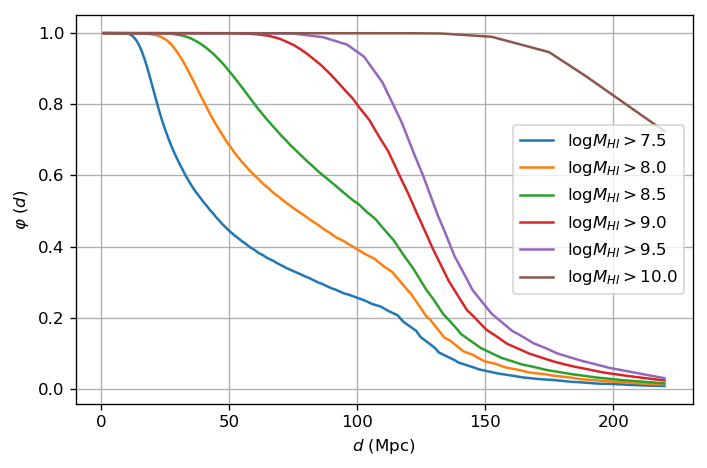

In [57]:
x = np.linspace(1, 220, 2500)

mlims = [7.5, 8, 8.5, 9, 9.5, 10]
smoothpoints = [101, 151, 301, 351, 401, 751]
yy = list()
for mlim, points in zip(mlims, smoothpoints):
    fint = survival_func(x, mlim, points)
    y = fint(x)
    yy.append(y)
    print(np.max(y))





plt.figure(dpi=120)
for mlim, y in zip(mlims, yy):
    plt.plot(x, y, label=r"$\log M_{{HI}}>{{{:.1f}}}$".format(mlim))
plt.xlabel(r"$d\ (\mathrm{Mpc})$")
plt.ylabel(r"$\varphi\ (d)$")
plt.grid()
plt.legend()
plt.tight_layout()
# plt.ylim(0.0-0.1, 1.0+0.1)
plt.savefig("../../Plots/HIsurf_smooth.pdf", dpi=180)
plt.show()

In [ ]:
!ls ../../BAM/a100springfull.fits

In [ ]:
from astropy.io import fits

In [ ]:
data = fits.open("../../BAM/a100springfull.fits")[1].data

In [ ]:
plt.figure(dpi=120)
plt.hist(data['logMH'], bins='auto')
plt.show()

In [ ]:
data.dtype.names

In [ ]:
HImass = data['logMH']
STmass = data['SERSIC_MASS']
IDS = np.where(np.isfinite(STmass))[0]
HImass = 10**HImass[IDS]
STmass = STmass[IDS]

In [ ]:
mass = np.log10(HImass+STmass)

In [ ]:
ID2 = np.where(mass>9.8)

In [ ]:
plt.figure(dpi=120)
plt.hist(mass, bins='auto')
plt.show()

In [ ]:
np.where(logMS>10.2)[0].size

In [ ]:
plt.figure(dpi=120)
plt.hist(np.log10(HImass[ID2]), bins='auto')
plt.show()